In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time
import random

import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
# from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR
import tifffile
from fastai.vision.all import *

from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer
import itertools as it

is_amp = True
import logging

from sklearn.model_selection import KFold


from itertools import repeat
import collections.abc
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/lakshita/somusan/hubmap_kaggle/nbs/timm-pytorch-image-models/pytorch-image-models-master')
import timm

sys.path.append('/home/lakshita/somusan/hubmap_kaggle/nbs/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params

/home/lakshita/somusan/hubmap_kaggle/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/kaggle/working/'
pretrain_dir = '/kaggle/input/swin-tiny-small-22k-pretrained/'

TRAIN = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-2022-256x256/train'
MASKS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-2022-256x256/masks'
LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/test.csv'

df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")

In [3]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x

    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s' % ((time.time() - start_timer))

    return text

In [4]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="augmentations"><center>Augmentations</center></h3>

In [5]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [6]:
image_size = 256

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k, d.get(k,0), d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(tifffile.imread(os.path.join(TRAIN, f'{d.id}.tiff')), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        #print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)


        r ={}
        r['index']= index
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask)
        return r

In [7]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(nn.Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class config:
    pretrained_root = '/home/lakshita/somusan/hubmap_kaggle/nbs/efficientnet-pytorch/'
    efficient_net_encoders = {
        "efficientnet-b0": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (3, 5, 9, 16),
            "weight_path": pretrained_root + "efficientnet-b0-08094119.pth"
        },
        "efficientnet-b1": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (5, 8, 16, 23),
            "weight_path": pretrained_root + "efficientnet-b1-dbc7070a.pth"
        },
        "efficientnet-b2": {
            "out_channels": (3, 32, 24, 48, 120, 352),
            "stage_idxs": (5, 8, 16, 23),
            "weight_path": pretrained_root + "efficientnet-b2-27687264.pth"
        },
        "efficientnet-b3": {
            "out_channels": (3, 40, 32, 48, 136, 384),
            "stage_idxs": (5, 8, 18, 26),
            "weight_path": pretrained_root + "efficientnet-b3-c8376fa2.pth"
        },
        "efficientnet-b4": {
            "out_channels": (3, 48, 32, 56, 160, 448),
            "stage_idxs": (6, 10, 22, 32),
            "weight_path": pretrained_root + "efficientnet-b4-e116e8b3.pth"
        },
        "efficientnet-b5": {
            "out_channels": (3, 48, 40, 64, 176, 512),
            "stage_idxs": (8, 13, 27, 39),
            "weight_path": pretrained_root + "efficientnet-b5-586e6cc6.pth"
        },
        "efficientnet-b6": {
            "out_channels": (3, 56, 40, 72, 200, 576),
            "stage_idxs": (9, 15, 31, 45),
            "weight_path": pretrained_root + "efficientnet-b6-c76e70fd.pth"
        },
        "efficientnet-b7": {
            "out_channels": (3, 64, 48, 80, 224, 640),
            "stage_idxs": (11, 18, 38, 55),
            "weight_path": pretrained_root + "efficientnet-b7-dcc49843.pth"
        }
    }
    model = 'efficientnet-b7'
    
class EfficientNetEncoder(EfficientNet):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)
        
        cfg = config.efficient_net_encoders[model_name]

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc
        self.load_state_dict(torch.load(cfg['weight_path']))

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)  
        

class EffUnet(nn.Module):
    def __init__(self, model_name, stride=1):
        super().__init__()
        
        cfg = config.efficient_net_encoders[model_name]
        stage_idxs = cfg['stage_idxs']
        out_channels = cfg['out_channels']
        
        self.encoder = EfficientNetEncoder(stage_idxs, out_channels, model_name)

        #aspp with customized dilatations
        self.aspp = ASPP(out_channels[-1], 256, out_c=384, 
                         dilations=[stride*1, stride*2, stride*3, stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(384, out_channels[-2], 256)
        self.dec3 = UnetBlock(256, out_channels[-3], 128)
        self.dec2 = UnetBlock(128, out_channels[-4], 64)
        self.dec1 = UnetBlock(64, out_channels[-5], 32)
        self.fpn = FPN([384, 256, 128, 64], [16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
        self.rgb = RGB()
        
    def forward(self, batch):
        x = batch['image']
        B, C, H, W = x.shape
        x = self.rgb(x)
        enc0, enc1, enc2, enc3, enc4 = self.encoder(x)[-5:]
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5), enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x, size = 512, mode = 'bilinear')
        return x

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="folds"><center>Folds</center></h3>

In [8]:
def make_fold(fold=3):
    df = pd.read_csv('/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv')

    num_fold = 5
    skf = KFold(n_splits=num_fold, shuffle=True,random_state=42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

In [9]:
def compute_dice_score(probability, mask, smooth = 1):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

In [10]:
def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

In [11]:
# organ_threshold = {
#     'kidney': 0.50,
#     'prostate': 0.50,
#     'largeintestine': 0.50,
#     'spleen': 0.50,
#     'lung': 0.20,
# }   

organ_threshold = {
    'Hubmap': {
        'kidney'        : 0.40,
        'prostate'      : 0.40,
        'largeintestine': 0.40,
        'spleen'        : 0.40,
        'lung'          : 0.10,
    },
    'HPA': {
        'kidney'        : 0.50,
        'prostate'      : 0.50,
        'largeintestine': 0.50,
        'spleen'        : 0.50,
        'lung'          : 0.10,
    },
}

In [12]:
# Stochastic Weight Averaging
# https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
def do_swa(checkpoint):
    skip = ['relative_position_index', 'num_batches_tracked']
    
    K = len(checkpoint)
    swa = None
    
    for k in range(K):
        state_dict = torch.load(checkpoint[k], map_location=lambda storage, loc: storage)['state_dict']
        if swa is None:
            swa = state_dict
        else:
            for k, v in state_dict.items():
                #print(k)
                if any(s in k for s in skip): continue
                swa[k] += v
    
    for k, v in swa.items():
        if any(s in k for s in skip): continue
        swa[k] /= K
    
    return swa

In [13]:
#root_dir = '../input/swin-10k'

In [14]:
# #out_dir = root_dir + '/result/upernet-swin-v1-tiny-aux5-768'
# all_df = []
# valid = {
#     0: [
#         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00004992.model.pth',
#         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00007776.model.pth',
#         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00009216.model.pth',
#         ],
#     1: [
#         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00007296.model.pth',
#         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00008736.model.pth',
#         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00009120.model.pth',
#         ],
#     2: [
#         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00005376.model.pth',
#         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00008832.model.pth',
#         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00009888.model.pth',
#         ],
#     3: [
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008019.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008910.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00009900.model.pth',
#         ],
# }

# all_score_df = []
# for f, checkpoint in valid.items():
#     if len(checkpoint)==0: 
#         continue

#     #project_name = out_dir.split('/')[-1]
#     #fold_dir = out_dir + '/fold-%d' % f

#     #checkpoint = [fold_dir + '/checkpoint' + c for c in checkpoint]
#     checkpoint = [c for c in checkpoint]
#     swa = do_swa(checkpoint)
#     torch.save({
#         'state_dict': swa,
#         'swa': [c.split('/')[-1] for c in checkpoint],
#     }, 
#         f'./fold-{f}-swa.pth')

#     net = Net().cuda()
#     state_dict = swa
#     net.load_state_dict(state_dict, strict=False)  # True

#     net = net.eval()
#     net.output_type = ['inference']

#     result = {
#         'id': [],
#         'probability': [],
#         'rle': [],
#     }

#     start_timer = time.time()
#     for t, d in df.iterrows():
        
#         fname = d['id']
#         image = tifffile.imread(f'../input/hubmap-organ-segmentation/test_images/{fname}.tiff')
#         image = image.astype(np.float32)/255
        
#         H, W, _ = image.shape

#         s = d.pixel_size / 0.4 * (image_size / 3000)
#         image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

#         image = image_to_tensor(image)
#         image = image.cuda()
#         batch = {
#             'image':
#                 torch.stack([
#                     image,
#                     torch.flip(image, [1]),
#                     torch.flip(image, [2]),
#                 ]),  # simple TTA
#         }

#         probability = 0
#         with torch.no_grad():
#             with amp.autocast(enabled=is_amp):
#                 output = net(batch) 
#                 probability += F.interpolate(
#                     output['probability'], size=(H, W), mode='bilinear', align_corners=False, antialias=True)

#         # undo TTA
#         probability[1] = torch.flip(probability[1], [1])
#         probability[2] = torch.flip(probability[2], [2])
#         probability = probability.float().data.cpu().numpy().mean(0)[0]
#         #p = probability > organ_threshold[d.organ] 
#         p = probability > organ_threshold[d.data_source][d.organ] 
#         p = p.T
#         rle = rle_encode(p)
#         #rle = rle

#         result['rle'].append(rle)
#         result['probability'].append(p)
#         result['id'].append(fname)
#         print('\r', t, end='', flush=True)
#     print('')
#     submit_df = pd.DataFrame({'id': result['id'], 'rle': result['rle'], 'prob' : result['probability']})
#     print(submit_df)
#     all_df.append(submit_df)
#     print('submit_df ok!')
#     print('')

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [37]:
all_df = []
# valid = {
# #     0: [
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00004992.model.pth',
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00007776.model.pth',
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00009216.model.pth',
# #         ],
# #     1: [
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00007296.model.pth',
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00008736.model.pth',
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00009120.model.pth',
# #         ],
# #     2: [
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00005376.model.pth',
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00008832.model.pth',
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00009888.model.pth',
# #         ],
#     3: [
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008019.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008910.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00009900.model.pth',
#         ],
# }


result = {
        'id': [],
        'probability': [],
        'rle': [],
    }

start_timer = time.time()

df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
df = df[df['organ'] == 'lung']

for t, d in df.iterrows():

    fname = d['id']
    print(fname)
    image = tifffile.imread(f'/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/{fname}.tiff')
    image = image.astype(np.float32)/255
    
    H, W, _ = image.shape

    s = d.pixel_size / 0.4 * (image_size / 3000)
    image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

    image = image_to_tensor(image)
    image = image.cuda()
    batch = {
        'image':
            torch.stack([
                image,
                torch.flip(image, [1]),
                torch.flip(image, [2]),
            ]),  # simple TTA
    }
    
    use = 0
    probability = 0
    with torch.no_grad():
        with amp.autocast(enabled = True):
            
            net = EffUnet(config.model).cuda()
            state_dict = torch.load('/home/lakshita/somusan/hubmap_kaggle/nbs/result/effnetb7/fold-3/checkpoint/00008500.model.pth',
                        map_location=torch.device('cpu'))
            net.load_state_dict(state_dict['state_dict'])
#             state_dict = swa
#             net.load_state_dict(state_dict, strict=False)  # True

            net = net.eval()
#             net.output_type = ['inference']
            use += 1

            output = net(batch)
            #print(output['probability'].shape)
            probability += F.interpolate(
                output, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        #probability = probability / 4
        probability[0] = probability[0]   
        probability[1] = torch.flip(probability[1], [1])
        probability[2] = torch.flip(probability[2], [2])
        probability = probability.mean(0, keepdims=True)
        probability = probability[0,0].float()
        #probability = probability.float().data.cpu().numpy().mean(0)[0]
        
    probability = probability.data.cpu().numpy()
    #p = probability > organ_threshold[d.organ]
    p = probability > organ_threshold[d.data_source][d.organ]
    p = p.T

    rle = rle_encode(p.T)
    
    result['rle'].append(rle)
    result['probability'].append(p.T)
    result['id'].append(fname)
    print('\r', t, end='', flush=True)
    print('')
    break
submit_df = pd.DataFrame({'id': result['id'], 'rle': result['rle']})
print(submit_df)
print('submit_df ok!')
print('')

10488
 3
      id  \
0  10488   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       rle  
0  4713994 7 4716992 11 4719991 14 4722990 16 4725989 19 4728987 22 4731986 25 4734985 28 4737984 30 4740983 33 4743982 36 4746982 37 4749981 39 4752980 42 4753182 8 4755979 44 4756179 15 4758979 46 4759177 21 4761978 48 4762175 28 4764977 50 4765172 35 4767977 52 4768170 40 4770976 54 4771167 45 4773976 55 4774164 50 4776975 58 4777162 54 4779975 59 4780159 

[10488]


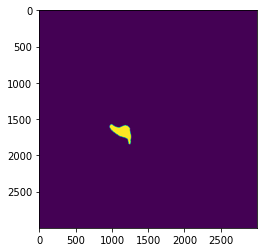

In [38]:
print(result['id'])
plt.imshow(result['probability'][0])

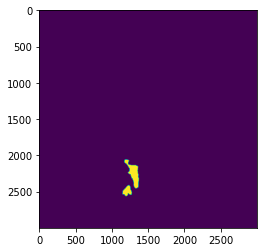

In [34]:
plt.imshow(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/10488.png",0))

In [ ]:
result['probability'][0].shape

(3000, 3000)

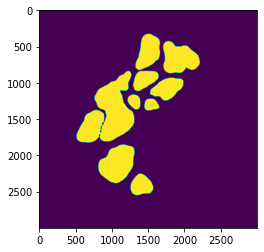

In [ ]:
plt.imshow(rle_decode(result['rle'][0], result['probability'][0].shape))

In [ ]:
CONFIG = {
    "in_channels" :3,
    "num_classes": 1,
    "BATCH_SIZE" : 8,
    "NUM_EPOCHS" : 40,
    "n_accumulate": 1,
    "competition": "HuBMAP-Kaggle", # HuBMAP-Kaggle
    "model_name": "Vanilla_Unet",
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", 
    "AUG": "No",
    "SEED": 42,
    "opt": 'Adam',
    "Normalization": "L2",
    "img_size": 256
}

In [ ]:
import wandb

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
#     anonymous = None
# except:
#     anonymous = "must"
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project="PogChamp2 Baseline")
run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['semantic segmentation', CONFIG['model_name']],
                 anonymous='must',
                 name = "model_load_1",
                 notes = "")

In [ ]:
wandb.save('/home/lakshita/somusan/hubmap_kaggle/nbs/result/effnetb7/fold-3/checkpoint/00008415.model.pth')

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/home/lakshita/somusan/hubmap_kaggle/nbs/wandb/run-20220819_162202-19bbi4xt/files/00008415.model.pth']

In [ ]:
best_model = wandb.restore('00008415.model.pth')

In [ ]:
!pwd

/home/lakshita/somusan/hubmap_kaggle/nbs


In [ ]:
!ls -la

total 714344
drwxrwxr-x 8 lakshita lakshita      4096 Aug 19 16:19  .
drwxrwxr-x 7 lakshita lakshita      4096 Aug 18 22:54  ..
-rw-rw-r-- 1 lakshita lakshita 721737883 Aug 19 00:00 'archive (1).zip'
-rw-rw-r-- 1 lakshita lakshita   1322432 Aug 18 23:59  archive.zip
drwxrwxr-x 2 lakshita lakshita      4096 Aug 19 00:16  checkpoint
drwxrwxr-x 3 lakshita lakshita      4096 Aug 19 00:00  efficientnet-pytorch
-rw-rw-r-- 1 lakshita lakshita    530766 Aug 15 20:18  effnetb0_unet_org_data.ipynb
-rw-rw-r-- 1 lakshita lakshita     60477 Aug 19 12:34  effnetb7-fold3.ipynb
-rw-rw-r-- 1 lakshita lakshita      2316 Aug 19 00:12  effnetb7-train.ipynb
-rw-rw-r-- 1 lakshita lakshita    417346 Aug 19 16:26  effnetb7-unet-infer.ipynb
-rw-rw-r-- 1 lakshita lakshita     48542 Aug 19 15:06  hubmap-effnet-b7-unet-train.ipynb
-rw-rw-r-- 1 lakshita lakshita    766565 Aug 15 19:49  hubmap-effnetunet-tiled-data-no-schd-train.ipynb
-rw-rw-r-- 1 lakshita lakshita    432226 Jul 31 11:16  hubmap-effnetunet-tiled-da

In [ ]:
result['id']

[10044, 10274, 10392, 10488, 10610, 10611, 10651, 10666, 10703, 10892]

(2023, 2023)


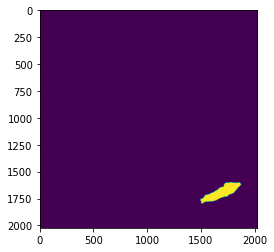

In [ ]:
# plt.subplot(1,2,1)
plt.imshow(result['probability'][0])

# plt.subplot(1,2,2)
# plt.imshow(result['probability'][0].T)

print(result['probability'][0].shape)

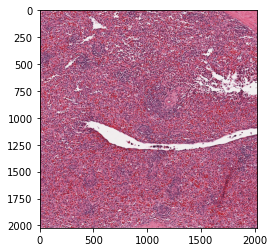

In [ ]:
plt.imshow(plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/test_images/10078.tiff"))

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(p)

In [ ]:
all_df = []


result = {
        'id': [],
        'probability': [],
        'rle': [],
    }

start_timer = time.time()
for t, d in df.iterrows():
    fname = d['id']
    image = tifffile.imread(f'/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/{fname}.tiff')
    image = image.astype(np.float32)/255


    H, W, _ = image.shape
    print("before IMAGE SIZE", image.shape)

    s = d.pixel_size / 0.4 * (image_size / 3000)
    image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)
    print("AFTER IMAGE SIZE", image.shape)

    image = image_to_tensor(image)
    image = image.cuda()
    batch = {
        'image':
            torch.stack([
                image,
                torch.flip(image, [1]),
                torch.flip(image, [2]),
            ]),  # simple TTA
    }
    
    use = 0
    probability = 0
    with torch.no_grad():
        with amp.autocast(enabled = True):
            
            net = EffUnet(config.model).cuda()
            state_dict = torch.load('/home/lakshita/somusan/hubmap_kaggle/nbs/result/effnetb7/fold-3/checkpoint/00008910.model.pth',
                        map_location=torch.device('cpu'))
            net.load_state_dict(state_dict['state_dict'])

            net = net.eval()

            use += 1

            output = net(batch)

            probability += F.interpolate(
                output, size=(H, W), mode='bilinear', align_corners=False, antialias=True)


        probability[0] = probability[0]   
        probability[1] = torch.flip(probability[1], [1])
        probability[2] = torch.flip(probability[2], [2])
        probability = probability.mean(0, keepdims=True)
        probability = probability[0,0].float()

        
    probability = probability.data.cpu().numpy()

    p = probability > organ_threshold[d.data_source][d.organ]
    p = p.T

    rle = rle_encode(p)
    
    result['rle'].append(rle)
    result['probability'].append(p)
    result['id'].append(fname)
    print('\r', t, end='', flush=True)
    print('')

    break
submit_df = pd.DataFrame({'id': result['id'], 'rle': result['rle']})
print(submit_df)
print('submit_df ok!')
print('')

before IMAGE SIZE (3000, 3000, 3)
AFTER IMAGE SIZE (256, 256, 3)
 0
      id  \
0  10044   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       rle  
0  1555737 12 1558724 30 1561719 38 1564715 46 1567711 53 1570708 60 1573704 66 1576702 70 1579699 75 1582696 80 1585693 85 1588691 88 1591688 93 1594686 96 1597684 99 1600681 104 1603679 107 1606677 110 1609675 113 1612673 116 1615671 119 1618669 122 1621667 125 1624665 128 1627663 131 1630661 134 16

In [ ]:
result['id']

[10044]

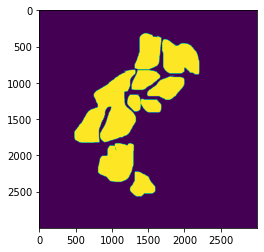

In [ ]:
plt.imshow(plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/10044.png"))

(3, 256, 256)


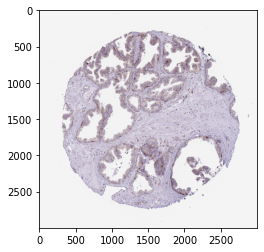

In [ ]:
print(image.cpu().detach().numpy().shape)
plt.imshow(plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff"))

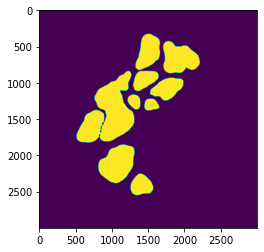

In [ ]:
plt.imshow(result['probability'][0].T)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
submit_df.to_csv('submission.csv',index=False)